# Topic Modelling

**Goals**

- Can the reviews be classified according to emergent topics? (e.g., can review j be made up of 0.5 topic “service; speed; sympathy”, and 0.3 topic “ambiance; decoration; furniture”?)

- What do the emergent topics  mean?  (i.e.,  are  they  meaningful  regarding  the  project’s context?) 

- Can relevant insights be extracted from the topics?

## Imports

In [ ]:
#pip install bertopic

In [122]:
import numpy as np
import pandas as pd
import regex as re
import nltk

#Preprocessing
#from utils import pipeline_v2
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from textblob import TextBlob
sent_tokenizer = PunktSentenceTokenizer()

#Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Classification and Metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from bertopic import BERTopic
from umap import UMAP

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm

In [83]:
# Load the dataset
reviews = pd.read_csv('C:/Users/msard/OneDrive/Desktop/Data Science/Fall 2024/Text Mining/Hyderabadi-Word-Soup/data_hyderabad/10k_reviews.csv')

## Preprocessing

In [54]:
class MainPipeline(BaseEstimator):
    def __init__(self, 
                 print_output = False, 
                 no_emojis = True, 
                 no_hashtags = True,
                 hashtag_retain_words = True,
                 no_newlines = True,
                 no_urls = True,
                 no_punctuation = True,
                 no_stopwords = True,
                 custom_stopwords = [],
                 convert_diacritics = True, 
                 lowercase = True, 
                 lemmatized = True,
                 list_pos = ["n","v","a","r","s"],
                 pos_tags_list = "no_pos",
                 tokenized_output = False):
        
        self.print_output = print_output 
        self.no_emojis = no_emojis
        self.no_hashtags = no_hashtags
        self.hashtag_retain_words = hashtag_retain_words
        self.no_newlines = no_newlines
        self.no_urls = no_urls
        self.no_punctuation = no_punctuation
        self.no_stopwords = no_stopwords
        self.custom_stopwords = custom_stopwords
        self.convert_diacritics = convert_diacritics
        self.lowercase = lowercase
        self.lemmatized = lemmatized
        self.list_pos = list_pos
        self.pos_tags_list = pos_tags_list
        self.tokenized_output = tokenized_output

    def regex_cleaner(self, raw_text):

        #patterns
        newline_pattern = "(\\n)"
        hashtags_at_pattern = "([#\@@\u0040\uFF20\uFE6B])"
        hashtags_ats_and_word_pattern = "([#@]\w+)"
        emojis_pattern = "([\u2600-\u27FF])"
        url_pattern = "(?:\w+:\/{2})?(?:www)?(?:\.)?([a-z\d]+)(?:\.)([a-z\d\.]{2,})(\/[a-zA-Z\/\d]+)?" ##Note that this URL pattern is *even better*
        punctuation_pattern = "[\u0021-\u0026\u0028-\u002C\u002E-\u002F\u003A-\u003F\u005B-\u005F\u007C\u2010-\u2028\ufeff`]+"
        apostrophe_pattern = "'(?=[A-Z\s])|(?<=[a-z\.\?\!\,\s])'"
        separated_words_pattern = "(?<=\w\s)([A-Z]\s){2,}"
        ##note that this punctuation_pattern doesn't capture ' this time to allow our tokenizer to separate "don't" into ["do", "n't"]
        
        if self.no_emojis == True:
            clean_text = re.sub(emojis_pattern,"",raw_text)
        else:
            clean_text = raw_text

        if self.no_hashtags == True:
            if self.hashtag_retain_words == True:
                clean_text = re.sub(hashtags_at_pattern,"",clean_text)
            else:
                clean_text = re.sub(hashtags_ats_and_word_pattern,"",clean_text)
            
        if self.no_newlines == True:
            clean_text = re.sub(newline_pattern," ",clean_text)

        if self.no_urls == True:
            clean_text = re.sub(url_pattern,"",clean_text)
        
        if self.no_punctuation == True:
            clean_text = re.sub(punctuation_pattern,"",clean_text)
            clean_text = re.sub(apostrophe_pattern,"",clean_text)

        return clean_text

    def lemmatize_all(self, token):
    
        wordnet_lem = nltk.stem.WordNetLemmatizer()
        for arg_1 in self.list_pos[0]:
            token = wordnet_lem.lemmatize(token, arg_1)
        return token

    def main_pipeline(self, raw_text):
        
        """Preprocess strings according to the parameters"""
        if self.print_output == True:
            print("Preprocessing the following input: \n>> {}".format(raw_text))

        clean_text = self.regex_cleaner(raw_text)

        if self.print_output == True:
            print("Regex cleaner returned the following: \n>> {}".format(clean_text))

        tokenized_text = nltk.tokenize.word_tokenize(clean_text)

        tokenized_text = [re.sub("'m","am",token) for token in tokenized_text]
        tokenized_text = [re.sub("n't","not",token) for token in tokenized_text]
        tokenized_text = [re.sub("'s","is",token) for token in tokenized_text]

        if self.no_stopwords == True:
            stopwords = nltk.corpus.stopwords.words("english")
            tokenized_text = [item for item in tokenized_text if item.lower() not in stopwords]
        
        if self.convert_diacritics == True:
            tokenized_text = [unidecode(token) for token in tokenized_text]

        if self.lemmatized == True:
            tokenized_text = [self.lemmatize_all(token) for token in tokenized_text]
    
        if self.no_stopwords == True:
            tokenized_text = [item for item in tokenized_text if item.lower() not in self.custom_stopwords]

        if self.pos_tags_list == "pos_list" or self.pos_tags_list == "pos_tuples" or self.pos_tags_list == "pos_dictionary":
            pos_tuples = nltk.tag.pos_tag(tokenized_text)
            pos_tags = [pos[1] for pos in pos_tuples]
        
        if self.lowercase == True:
            tokenized_text = [item.lower() for item in tokenized_text]
        
        if self.pos_tags_list == "pos_list":
            return (tokenized_text, pos_tags)
        elif self.pos_tags_list == "pos_tuples":
            return pos_tuples   
        
        else:
            if self.tokenized_output == True:
                return tokenized_text
            else:
                detokenizer = TreebankWordDetokenizer()
                detokens = detokenizer.detokenize(tokenized_text)
                if self.print_output == True:
                    print("Pipeline returning the following result: \n>> {}".format(str(detokens)))
                return str(detokens)

In [84]:
reviews.dropna(subset=['Review'], inplace=True)
reviews['Review'] = reviews['Review'].astype(str)

preprocessor = MainPipeline()
reviews['Preprocessed_Review'] =\
      reviews['Review'].map(lambda content: preprocessor.main_pipeline(content))

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(reviews['Preprocessed_Review'])

## Topic Modelling

We'll use Latent Dirichlet Allocation and BERT

### LDA

In [87]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10  # Number of topics
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(random_state=42)

In [88]:
# Extract top words for each topic
def get_top_words(model, feature_names, no_top_words):
    top_words_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        top_words_dict[topic_idx] = " ".join(top_words)
    return top_words_dict

no_top_words = 5
tf_feature_names = vectorizer.get_feature_names_out()
top_words_dict = get_top_words(lda, tf_feature_names, no_top_words)

In [89]:
def display_topics(model, feature_names, no_top_words):
    for i, topic in enumerate(model.components_):
        print(f"Topic {i}:")
        print(" ".join([feature_names[j] for j in topic.argsort()[ : -no_top_words-1 : -1]]))
        
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
place food good time drink
Topic 1:
place best dish burger restaurant
Topic 2:
cake momos coffee place breakfast
Topic 3:
chicken ordered biryani good paneer
Topic 4:
good food place service ambience
Topic 5:
chicken good ordered food taste
Topic 6:
order food ordered time delivery
Topic 7:
biryani bad food taste dont
Topic 8:
veg good food starter taste
Topic 9:
cream ice good place chocolate


In [ ]:
# Assign topic names to reviews
topic_distribution = lda.transform(X)

reviews['Topics_LDA'] = topic_distribution.tolist()

### BERTopic

In [123]:
# Initiate UMAP
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)

# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)

# Run BERTopic model
topics, probabilities = topic_model.fit_transform(reviews['Preprocessed_Review'])

In [124]:
# Get the list of topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4363,-1_food_place_good_service,"[food, place, good, service, ambience, great, ...",[nothing ask nice place good service excellent...
1,0,602,0_biryani_biriyani_chicken_mutton,"[biryani, biriyani, chicken, mutton, ordered, ...",[biryani good worst experience biryani hyderab...
2,1,462,1_manager_table_rude_even,"[manager, table, rude, even, worst, customer, ...",[visited place team lunch experience pathetic ...
3,2,370,2_good_boy_bhehave_goodgoodgoodgoodgoodgoodgoo...,"[good, boy, bhehave, goodgoodgoodgoodgoodgoodg...","[good, good, good]"
4,3,185,3_buffet_spread_lunch_main,"[buffet, spread, lunch, main, course, dessert,...",[visited place team lunch opted lunch buffet h...
...,...,...,...,...,...
105,104,11,104_schezwan_fried_rice_pao,"[schezwan, fried, rice, pao, chilli, tried, ch...",[tried chicken hot n sour soup chilli garlic c...
106,105,10,105_delivered_expected_yet_late,"[delivered, expected, yet, late, product, 25, ...","[delivered, yet delivered, delivered expected]"
107,106,10,106_navratri_sabudana_thali_kheer,"[navratri, sabudana, thali, kheer, fasting, ma...",[navratrifoodreview got chance review navratri...
108,107,10,107_pork_67_grill_perfect,"[pork, 67, grill, perfect, burger, flavor, gd,...",[located busy street kondapur one gain quite a...


In [126]:
# Get top 10 terms for a topic
topic_model.get_topic(0)

[('biryani', 0.06901012997881327),
 ('biriyani', 0.01900263903974032),
 ('chicken', 0.017362980709374715),
 ('mutton', 0.01621388249991699),
 ('ordered', 0.014043617456201817),
 ('taste', 0.013308497724405828),
 ('piece', 0.013061260315993611),
 ('quantity', 0.010959766378392676),
 ('dum', 0.010088283546815582),
 ('worst', 0.009957009138044934)]

In [125]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=12)

In [127]:
# Visualize term rank decrease
topic_model.visualize_term_rank()

In [128]:
# Visualize intertopic distance
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_documents()
# This uses UMAP to reduce the dimensions to 2D

In [130]:
# Visualize connections between topics using hierachical clustering
topic_model.visualize_hierarchy()

In [132]:
# Visualize similarity using heatmap
topic_model.visualize_heatmap()

In [131]:
# Visualize probability distribution
topic_model.visualize_distribution(topic_model.probabilities_[0], min_probability=0.015)

## Extract Insights

### Dominant Topics

In [ ]:
def get_dominant_topic(topic_dist):
    return np.argmax(topic_dist)

reviews['Dominant_Topic'] = reviews['Topic_Distribution'].apply(get_dominant_topic)

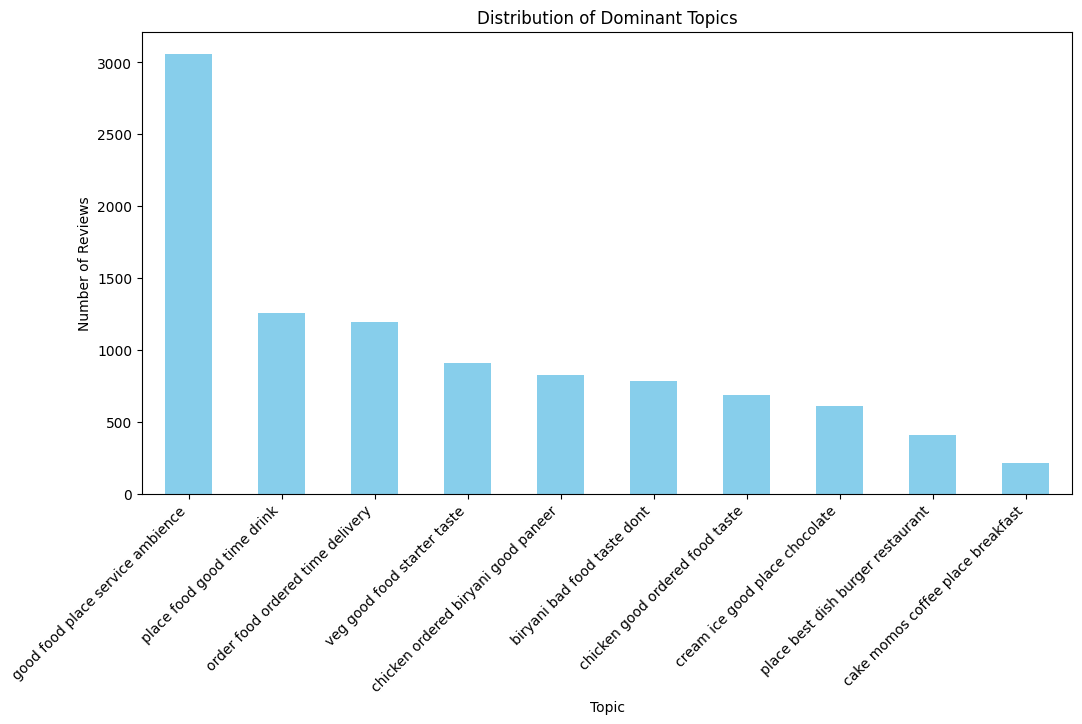

In [115]:
# Map topic numbers to names
topic_name_mapping = {idx: name for idx, name in top_words_dict.items()}
reviews['Dominant_Topic_Name'] = reviews['Dominant_Topic'].map(topic_name_mapping)

# Plot the distribution of dominant topics with topic names
topic_counts = reviews['Dominant_Topic_Name'].value_counts()
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()

In [111]:
# Sentiment Analysis
def get_sentiment(text):
    '''
    Computes the sentiment of a review using TextBlob
    '''
    return TextBlob(text).sentiment.polarity
reviews['Sentiment'] = reviews['Review'].apply(get_sentiment)

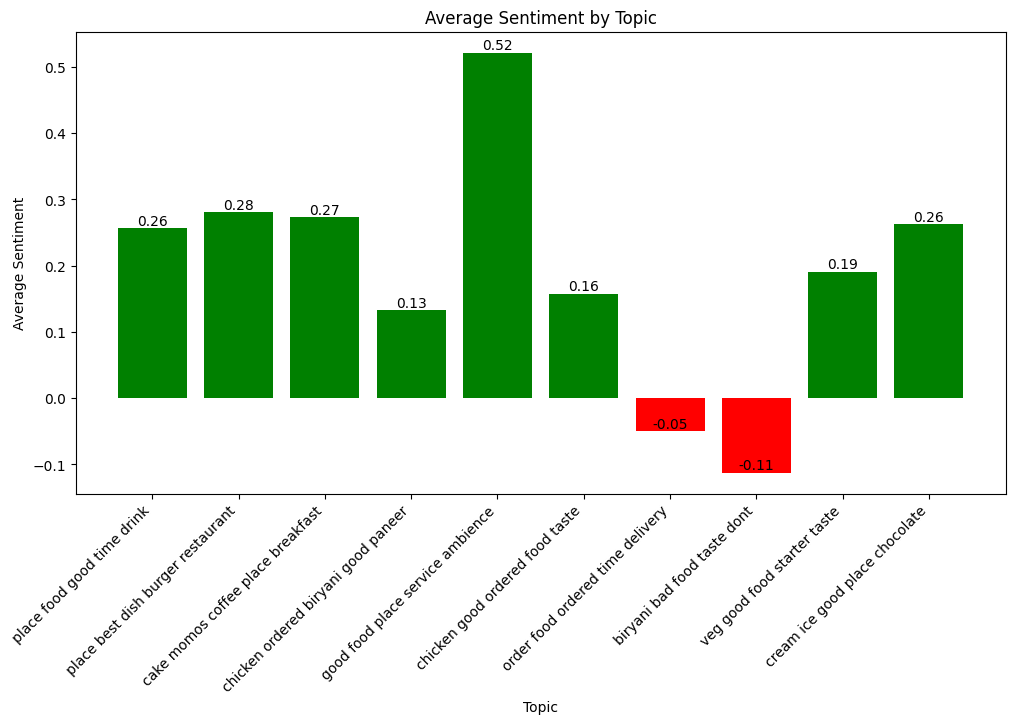

In [118]:
# Preparing data for plotting
topic_sentiment = reviews.groupby('Dominant_Topic')['Sentiment'].mean()
topic_names = [top_words_dict[topic] for topic in topic_sentiment.index]
sentiments = topic_sentiment.values

# Defining colors based on sentiment
colors = ['green' if sentiment > 0 else 'red' if sentiment < 0 else 'grey' for sentiment in sentiments]

# Plot the sentiment by topic
plt.figure(figsize=(12, 6))
bars = plt.bar(topic_names, sentiments, color=colors)
plt.xlabel('Topic')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment by Topic')
plt.xticks(rotation=45, ha='right')

# Adding sentiment values on top center of the bars
for bar, sentiment in zip(bars, sentiments):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(sentiment, 2), ha='center', va='bottom')

plt.show()

### Word Clouds

In [ ]:
# Color words based on sentiment polarity
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    sentiment = get_sentiment(word)
    if sentiment > 0:
        return "rgb(0, 255, 0)"  # Green
    elif sentiment < 0:
        return "rgb(255, 0, 0)"  # Red
    else:
        return "rgb(128, 128, 128)"  # Grey

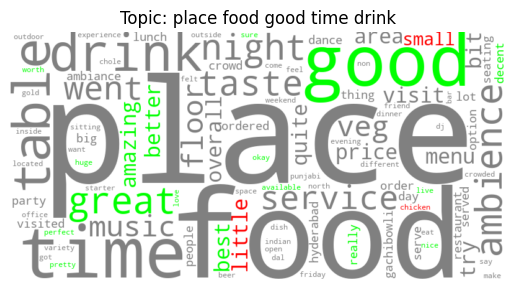

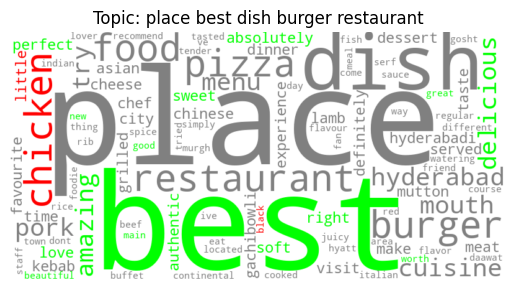

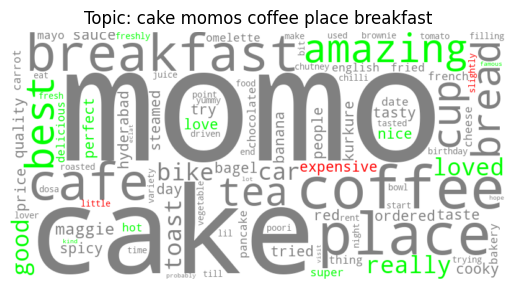

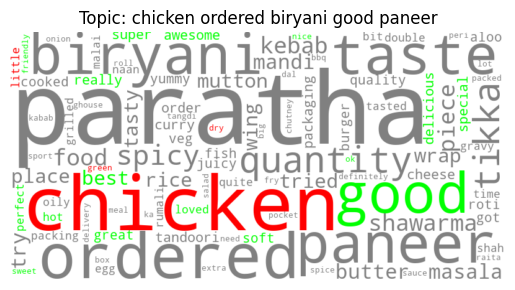

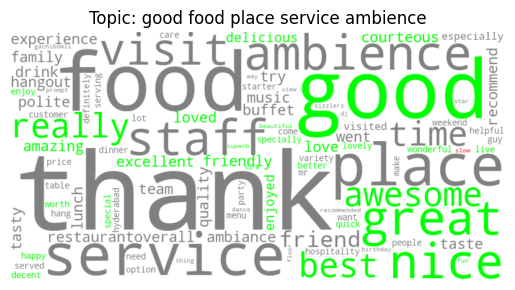

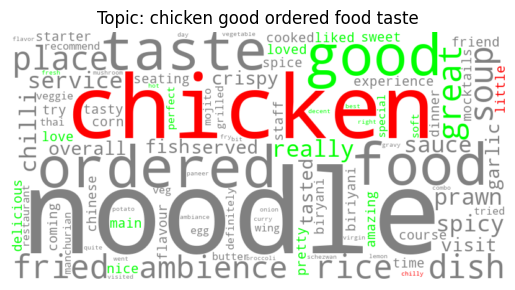

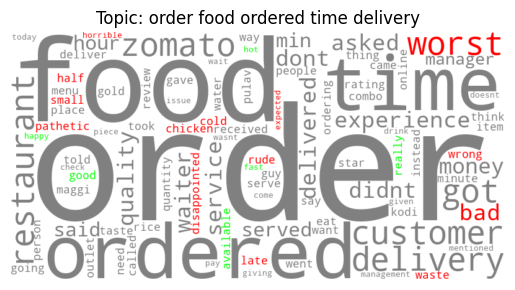

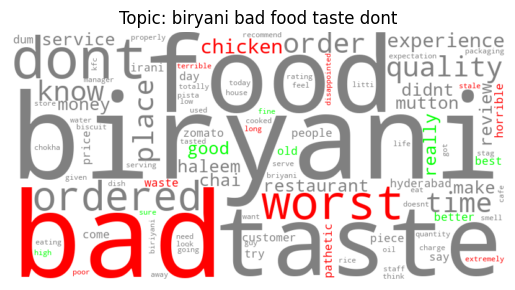

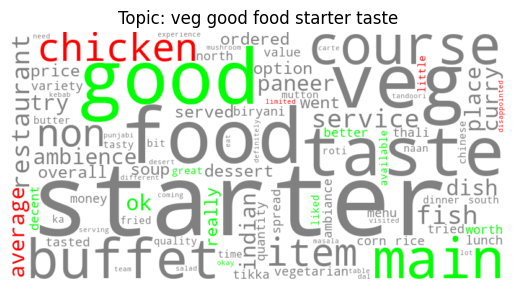

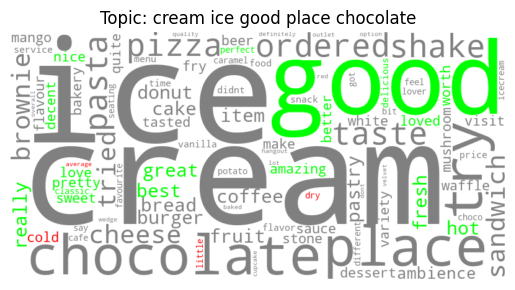

In [100]:
# Generates word clouds for each topic
no_top_words = 100

for topic_idx, topic_name in top_words_dict.items():
    topic_words = " ".join([tf_feature_names[i] for i in lda.components_[topic_idx].argsort()[:-no_top_words - 1:-1]])
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(topic_words)
    
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic: {topic_name}')
    plt.show()

### Evolution over time

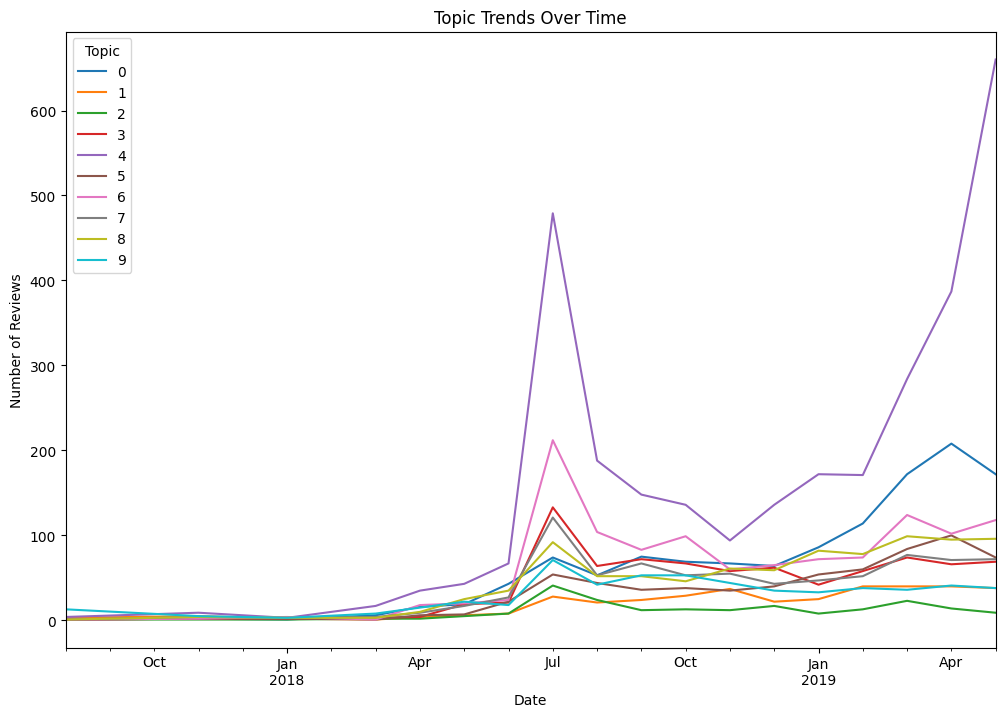

In [101]:
reviews['Time'] = pd.to_datetime(reviews['Time'])
topic_trends = reviews.groupby([reviews['Time'].dt.to_period('M'), 'Dominant_Topic']).size().unstack().dropna()
topic_trends.plot(kind='line', figsize=(12, 8))

plt.title('Topic Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend(title='Topic')
plt.show()

### Co-occurence

In [102]:
from itertools import combinations
from collections import Counter

def get_topic_pairs(topic_dist):
    '''
    Outputs pairs of topics with significant (>0.1) presence in a given review
    '''
    topic_dist_array = np.array(topic_dist)
    return list(combinations(np.where(topic_dist_array > 0.1)[0], 2))

# Getting topic pairs and counts
topic_pairs = reviews['Topic_Distribution'].apply(get_topic_pairs).tolist()
flat_topic_pairs = [pair for sublist in topic_pairs for pair in sublist]
topic_pair_counts = Counter(flat_topic_pairs)

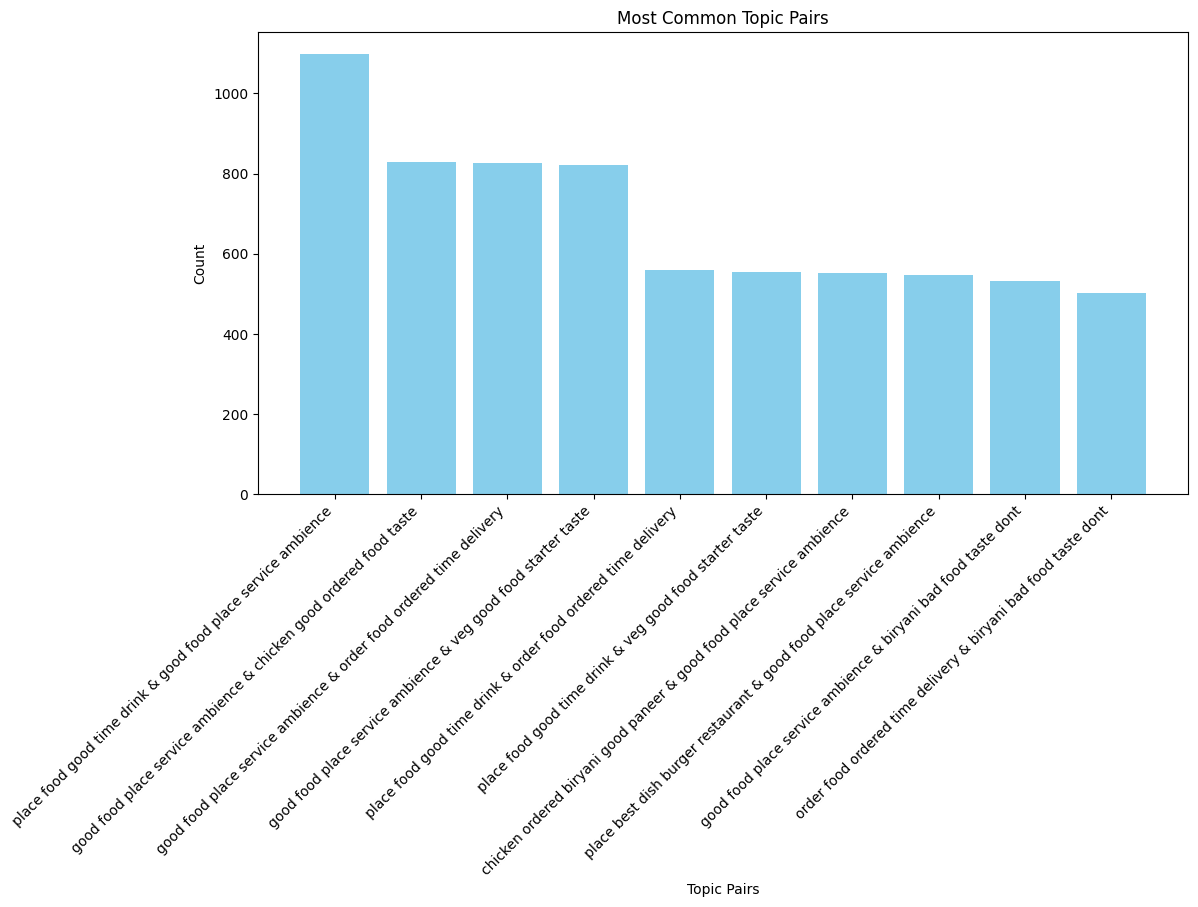

In [103]:
import numpy as np
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt

# Preparing data for plotting
most_common_pairs = topic_pair_counts.most_common(10)
pairs, counts = zip(*most_common_pairs)
pair_labels = [f"{top_words_dict[pair[0]]} & {top_words_dict[pair[1]]}" for pair in pairs]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(pair_labels, counts, color='skyblue')
plt.xlabel('Topic Pairs')
plt.ylabel('Count')
plt.title('Most Common Topic Pairs')
plt.xticks(rotation=45, ha='right')
plt.show()

### Topic distribution per reviwer

In [105]:
reviewer_topic_distribution = reviews.groupby('Reviewer')['Dominant_Topic'].value_counts(normalize=True).unstack().fillna(0)
print(reviewer_topic_distribution)

Dominant_Topic                 0    1    2    3    4    5    6    7    8    9
Reviewer                                                                     
#FOODPORN                    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
#chloesviews // CAH          0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
$ign                         0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
4mybanti                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
@FuloriBinaChutneyKaiseBani  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
ಅಭಿಷೇಕ್ ಉಪಾಧ್ಯ               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
ᴀɴ.ᴏᴛʜᴇʀ.sᴇɴ                 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
✌️✌️Reddy 🥂🍽️                1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
✔️ Sonu                      0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.0  0.5  0.0
🍛🍲🥗                          0.0  0.0  0.0  0.0  0.0  0.0  0.5  

C:\Users\msard\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127835 (\N{CURRY AND RICE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\msard\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127858 (\N{POT OF FOOD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\msard\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129367 (\N{GREEN SALAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


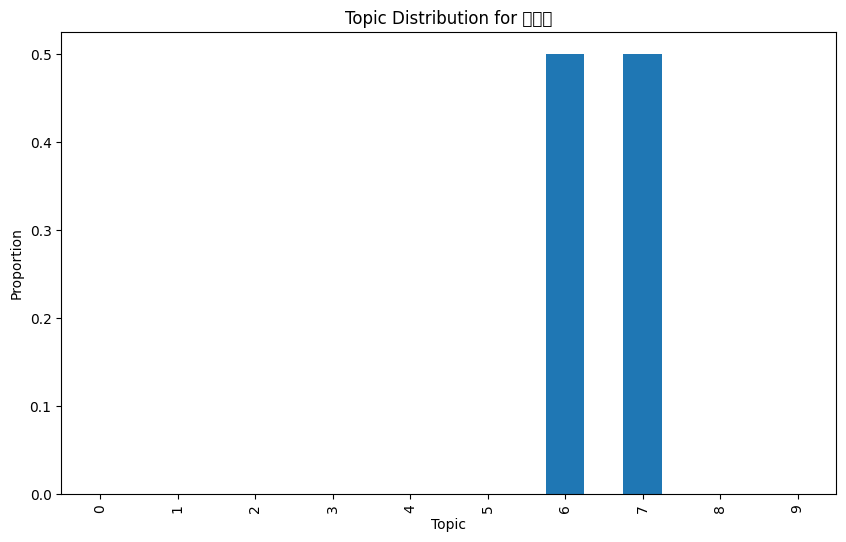

In [106]:
# Plotting topic distribution for a specific reviewer
reviewer = '🍛🍲🥗'
reviewer_topic_distribution.loc[reviewer].plot(kind='bar', figsize=(10, 6))
plt.title(f'Topic Distribution for {reviewer}')
plt.xlabel('Topic')
plt.ylabel('Proportion')
plt.show()

### Topic correlation with rating

Dominant_Topic
0    3.712411
1    4.219753
2    3.870370
3    3.420000
4    4.487912
5    3.473799
6    2.219064
7    2.169632
8    3.342134
9    3.732406
Name: Rating, dtype: float64


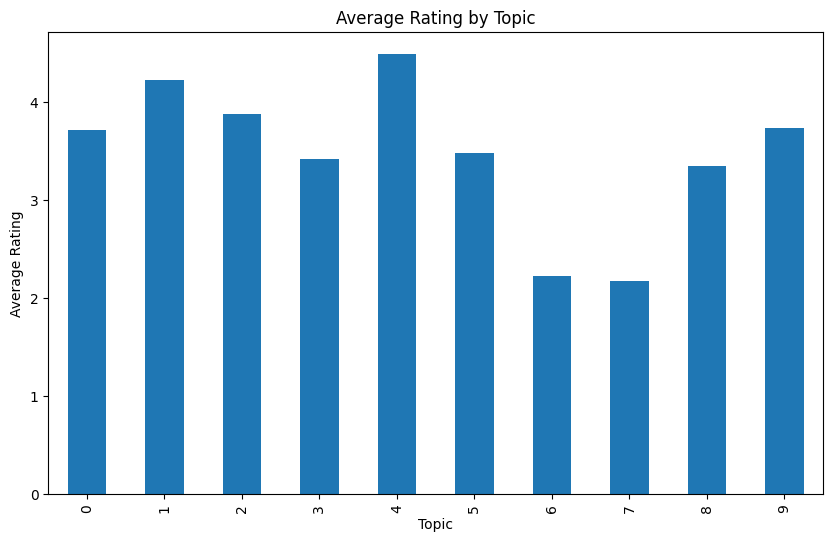

In [ ]:
# Preprocessing
reviews['Rating'] = pd.to_numeric(reviews['Rating'], errors='coerce')
reviews = reviews.dropna(subset=['Rating'])

topic_ratings = reviews.groupby('Dominant_Topic')['Rating'].mean()

# Plotting
topic_ratings.plot(kind='bar', figsize=(10, 6))
plt.title('Average Rating by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Rating')
plt.show()

### Impact of pictures

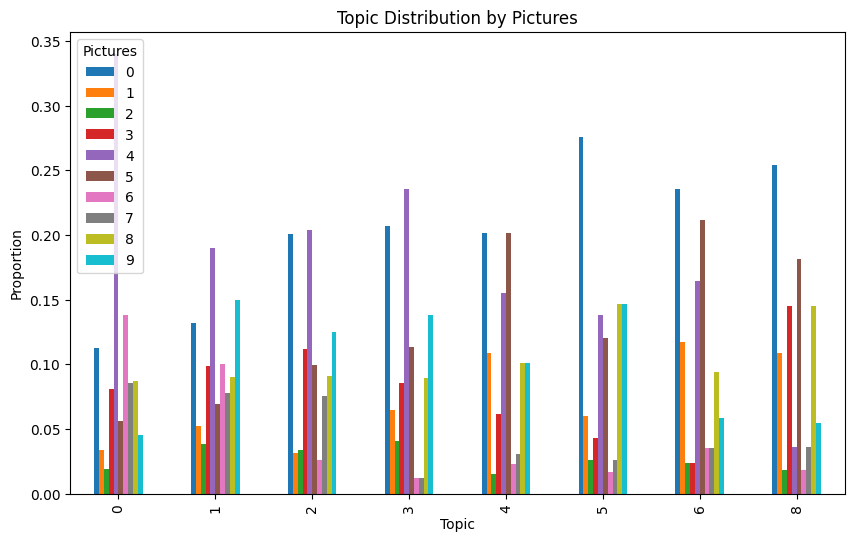

In [109]:
picture_topic_distribution = reviews.groupby('Pictures')['Dominant_Topic'].value_counts(normalize=True).unstack().dropna()

# Plot the topic distribution for reviews with and without pictures
picture_topic_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Topic Distribution by Pictures')
plt.xlabel('Topic')
plt.ylabel('Proportion')
plt.legend(title='Pictures')
plt.show()